In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
plt.rcParams.update({'font.size': 15})
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [5]:
with open('data_old/training_set_ip_temp_50Hz_tau7.p', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')
with open('data_old/training_set_op_temp_50Hz_tau7.p', 'rb') as fo:
        Y_train = pickle.load(fo, encoding='bytes')
with open('data_old/testing_set_ip_temp_50Hz_tau7.p', 'rb') as fo:
        X_test = pickle.load(fo, encoding='bytes')
with open('data_old/testing_set_op_temp_50Hz_tau7.p', 'rb') as fo:
        Y_test = pickle.load(fo, encoding='bytes')

In [6]:
# Y_train = Y_train_ori[:, ::5]
# Y_test = Y_test_ori[:, ::5]
Nsyn = 9
stimulus_duration_ms = Y_train.shape[1]
def list2array(X):
    ip_dim = Nsyn
    ip_num = int(len(X) / ip_dim)
    X_array = np.zeros((ip_num, ip_dim, stimulus_duration_ms))
    for i in range(ip_num):
        for j in range(ip_dim):
            for spike_time in X[i*Nsyn+j]:
                if spike_time <= 3000:
                    X_array[i,j,int(spike_time)] += 1
    return X_array

X_train_array = list2array(X_train)
X_test_array = list2array(X_test)

In [7]:
# pre-processing
## standardization
# Y_train_std = np.empty_like(Y_train)
# Y_test_std = np.empty_like(Y_test)
# Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
# Y_test_std = (Y_test - np.mean(Y_test)) / np.std(Y_test)

# X_train_std = list2array(X_train)
# X_test_std = list2array(X_test)
X_train_std = X_train_array
X_test_std = X_test_array

## from numpy to pytorch
Y_train_std = torch.tensor(Y_train).to(device)
Y_train_std = Y_train_std.to(torch.float32)

Y_test_std = torch.tensor(Y_test).to(device)
Y_test_std = Y_test_std.to(torch.float32)

X_train_std = torch.tensor(X_train_std).to(device)
X_train_std = X_train_std.to(torch.float32)

X_test_std = torch.tensor(X_test_std).to(device)
X_test_std = X_test_std.to(torch.float32)

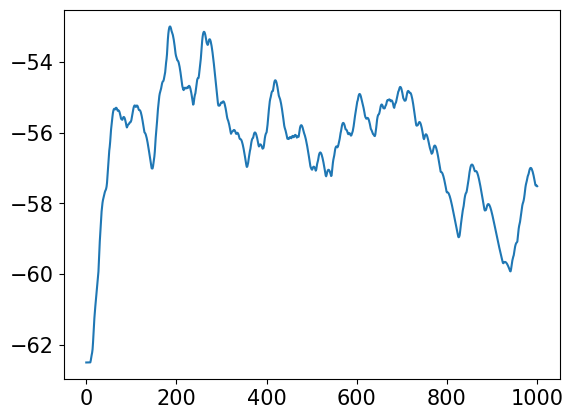

In [8]:
plt.plot(Y_test_std[2].cpu().detach().numpy())

In [9]:
train = Variable(X_train_std)

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, hidden_channels, T, tau1_init, tau2_init, weight_init):
        super(ConvLayer, self).__init__()
        self.hidden_channels = hidden_channels
        self.T = T
        self.tau1 = nn.Parameter(tau1_init * torch.ones(hidden_channels), requires_grad=True)
        # self.tau1 = nn.Parameter(5*torch.rand(hidden_channels), requires_grad=True)
        self.tau2 = nn.Parameter(tau2_init * torch.ones(hidden_channels), requires_grad=True)
        # self.tau2 = nn.Parameter(torch.rand(hidden_channels), requires_grad=True)
        self.conv_list = nn.ModuleList([nn.Conv1d(1, 1, kernel_size=self.T, padding = self.T-1, bias=False) for _ in range(hidden_channels)])
        self.weight = nn.Parameter(weight_init * torch.ones(hidden_channels), requires_grad=True)
        # self.weight = nn.Parameter(torch.rand(hidden_channels), requires_grad=True)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize convolution kernels
        for i in range(self.hidden_channels):
            kernel = torch.zeros(1, 1, self.T)
            for t in range(self.T):
                kernel[0, 0, t] = (torch.exp(-t / self.tau1[i]) - torch.exp(-t / self.tau2[i])) * self.weight[i]
            self.conv_list[i].weight.data = torch.flip(kernel, dims=[2])

    def forward(self, x):
        # Apply convolution operations
        y_list = []
        for i in range(self.hidden_channels):
            y = self.conv_list[i](x[:, i, :].unsqueeze(1))[:,:,:self.T]
            y_list.append(y)
        y = torch.cat(y_list, dim=1)
        return y.squeeze(2)

class BilinearLayer(nn.Module):
    def __init__(self, hidden_channels, kappa_init):
        super(BilinearLayer, self).__init__()
        self.hidden_channels = hidden_channels
        self.kappa = nn.Parameter(kappa_init * torch.ones((self.hidden_channels, self.hidden_channels)), requires_grad=True)
        # self.kappa = nn.Parameter(-0.02*torch.rand((self.hidden_channels, self.hidden_channels)), requires_grad=True)
        self.kappa.data = torch.triu(self.kappa.data)  # upper triangular matrix
        self.kappa.data.diagonal().fill_(0)  # diagonal elements are zero
        self.kappa.data = (self.kappa.data.requires_grad_(False) + self.kappa.data.requires_grad_(True))/2

    def forward(self, x):
        # Apply bilinear operation
        linear = x
        x = x.transpose(1, 2).unsqueeze(1)
        y_list = []
        for i in range(self.hidden_channels):
            for j in range(i+1, self.hidden_channels):
                y = x[:, :, :, i] * x[:, :, :, j]
                y = y * self.kappa[i, j]
                y_list.append(y)
        y = torch.cat(y_list, dim=1)
        y = torch.sum(y, dim=1) + torch.sum(linear, dim=1)
        return y
    
class BilinearNetwork(nn.Module):
    def __init__(self, hidden_channels, T, tau1_init, tau2_init, weight_init, kappa_init, bias_init):
        super(BilinearNetwork, self).__init__()
        self.conv_layer = ConvLayer(hidden_channels, T, tau1_init, tau2_init, weight_init)
        self.bilinear_layer = BilinearLayer(hidden_channels, kappa_init)
        self.bias = bias = nn.Parameter(torch.ones(1, requires_grad=True) * bias_init)
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.bilinear_layer(x) + self.bias
        return x

class LinearNetwork(nn.Module):
    def __init__(self, hidden_channels, T, tau1_init, tau2_init, weight_init, bias_init):
        super(LinearNetwork, self).__init__()
        self.conv_layer = ConvLayer(hidden_channels, T, tau1_init, tau2_init, weight_init)
        self.bias = bias = nn.Parameter(torch.ones(1, requires_grad=True) * bias_init)
    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.sum(x, dim=1) + self.bias
        return x


In [11]:
N_sample = X_train_std.shape[0]
hidden_channels = X_train_std.shape[1]
T = X_train_std.shape[2]
net = BilinearNetwork(hidden_channels=hidden_channels, T=T, tau1_init=50, tau2_init=5, weight_init=0.7, kappa_init=-0.01, bias_init=-62.5)
# net = LinearNetwork(hidden_channels=hidden_channels, T=T, tau1_init=50, tau2_init=5, weight_init=0.7,  bias_init=-62.5)
net.to(device)
error = nn.MSELoss()
learning_rate = 0.12
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

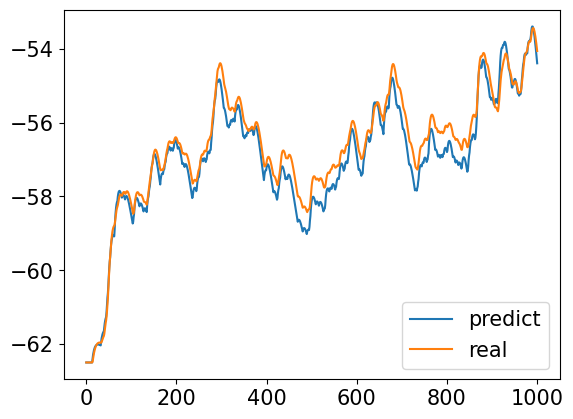

In [13]:
idx = 2
output = net(train)
plt.plot(output[idx].cpu().detach().numpy(), label='predict')
plt.plot(Y_train_std[idx].cpu().detach().numpy(), label='real')
plt.legend()

In [20]:
tr_labels = Variable(Y_train_std)
error(output, tr_labels)

tensor(30.5117, device='cuda:7', grad_fn=<MseLossBackward0>)

In [26]:
net = BilinearNetwork(hidden_channels=hidden_channels, T=T, tau1_init=40, tau2_init=6, weight_init=0.6, kappa_init=-0.02, bias_init=-62.5)
net.to(device)
error = nn.MSELoss()
learning_rate = 0.09
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [403]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float().to(device)
        self.Y = torch.from_numpy(Y).float().to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
# 假设batch_size为32
batch_size = 32

# 将X和Y分别作为训练集和标签集构造MyDataset对象
train_data = MyDataset(X_train_array, Y_train)
# 构造DataLoader对象
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [429]:
net = BilinearNetwork(hidden_channels=hidden_channels, T=T, tau1_init=50, tau2_init=5, weight_init=0.7, kappa_init=-0.01, bias_init=-62.5)
net.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.12)
loss_train_list = []
loss_test_list = []
test = Variable(X_test_std)
test_labels = Variable(Y_test_std)
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
for epoch in range(1500):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:        
        # Predict test dataset
        outputs = net(test) # Forward propagation
        loss_test = error(outputs, test_labels)
        outputs = net(train) # Forward propagation
        loss_train = error(outputs, tr_labels)
        # store loss and iteration
        loss_train_list.append(loss_train.data.item())
        loss_test_list.append(loss_test.data.item())
    if epoch % 100 == 0:
        print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))
print('Finished Training')


[1] loss: 11.177
[101] loss: 0.054
[201] loss: 0.047
[301] loss: 0.038
[401] loss: 0.029
[501] loss: 0.022
[601] loss: 0.017
[701] loss: 0.014
[801] loss: 0.012
[901] loss: 0.010
[1001] loss: 0.009
[1101] loss: 0.028
[1201] loss: 0.053
[1301] loss: 0.023
[1401] loss: 0.009
Finished Training


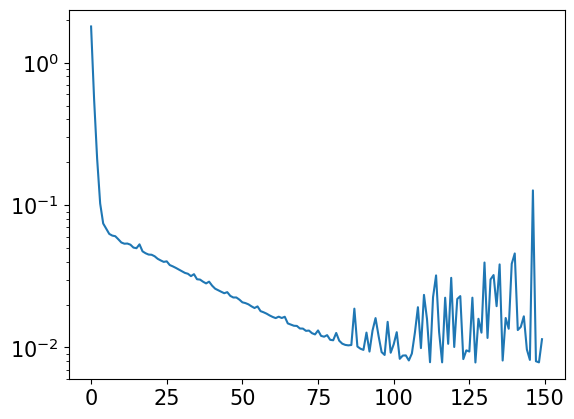

In [421]:
plt.semilogy(np.array(loss_train_list))

In [28]:
# ANN model training
num_epochs = 4000
loss_train_list = []
iteration_list = []
loss_test_list = []
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
test = Variable(X_test_std)
test_labels = Variable(Y_test_std)
for epoch in range(num_epochs):
    outputs = net(train) # Forward propagation
    loss_train = error(outputs, tr_labels)
    loss_train.backward() # Calculating gradients
    optimizer.step() # Update parameters
    optimizer.zero_grad() # Clear gradients
        
    if epoch % 70 == 0:        
        # Predict test dataset
        outputs = net(test) # Forward propagation
        loss_test = error(outputs, test_labels)
        # store loss and iteration
        loss_train_list.append(loss_train.data.item())
        iteration_list.append(epoch)
        loss_test_list.append(loss_test.data.item())
    if epoch % 400 == 0:
        print('Iteration: {}  Train_Loss: {}  Test_loss: {}'.format(epoch, loss_train.data.item(), loss_test.data.item()))
print('Final: Train_Loss: {}  '.format(loss_train.data.item()))

Iteration: 0  Train_Loss: 0.0073437439277768135  Test_loss: 0.00968735758215189
Iteration: 400  Train_Loss: 0.006956904660910368  Test_loss: 0.009209015406668186
Iteration: 800  Train_Loss: 0.006652911193668842  Test_loss: 0.008743726648390293
Iteration: 1200  Train_Loss: 0.006413622759282589  Test_loss: 0.008373124524950981
Iteration: 1600  Train_Loss: 0.006225008983165026  Test_loss: 0.008121185004711151
Iteration: 2000  Train_Loss: 0.006075963843613863  Test_loss: 0.007874819450080395
Iteration: 2400  Train_Loss: 0.0059580630622804165  Test_loss: 0.007676337845623493
Iteration: 2800  Train_Loss: 0.005864602979272604  Test_loss: 0.007515933830291033
Iteration: 3200  Train_Loss: 0.005790377967059612  Test_loss: 0.007406090386211872
Iteration: 3600  Train_Loss: 0.005731332115828991  Test_loss: 0.007296120282262564
Final: Train_Loss: 0.005684331990778446  


In [29]:
torch.save(net.state_dict(),'pars/net_ori.pt')

In [37]:
net.state_dict()['conv_layer.weight'],net.state_dict()['bilinear_layer.kappa']

(tensor([0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000],
        device='cuda:7'),
 tensor([[ 0.0000, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
          -0.0100],
         [ 0.0000,  0.0000, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
          -0.0100],
         [ 0.0000,  0.0000,  0.0000, -0.0100, -0.0100, -0.0100, -0.0100, -0.0100,
          -0.0100],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0100, -0.0100, -0.0100, -0.0100,
          -0.0100],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0100, -0.0100, -0.0100,
          -0.0100],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0100, -0.0100,
          -0.0100],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0100,
          -0.0100],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          -0.0100],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.

In [40]:
model = BilinearNetwork(hidden_channels=hidden_channels, T=T, tau1_init=50, tau2_init=5, weight_init=0.7, kappa_init=-0.01, bias_init=-62.5)
model.load_state_dict(torch.load('pars/net_after.pt'))
model_ori = BilinearNetwork(hidden_channels=hidden_channels, T=T, tau1_init=50, tau2_init=5, weight_init=0.7, kappa_init=-0.01, bias_init=-62.5)
model_ori.load_state_dict(torch.load('pars/net_ori.pt'))

<All keys matched successfully>

In [39]:
model.state_dict()['conv_layer.weight'],model.state_dict()['bilinear_layer.kappa']

(tensor([0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000]),
 tensor([[ 0.0000, -0.0178, -0.0029, -0.0718, -0.0168, -0.0094, -0.0126, -0.0076,
          -0.0189],
         [ 0.0000,  0.0000, -0.0287, -0.0728, -0.0252, -0.0036, -0.0209, -0.0135,
          -0.0074],
         [ 0.0000,  0.0000,  0.0000, -0.1035, -0.0394, -0.0201, -0.0272, -0.0121,
          -0.0175],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0666, -0.0328, -0.0357, -0.0568,
          -0.0221],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0603, -0.0329, -0.0426,
          -0.0040],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0254, -0.0193,
          -0.0172],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0171,
          -0.0176],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          -0.0263],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]]

In [42]:
model_ori.state_dict()['conv_layer.weight'],model_ori.state_dict()['bilinear_layer.kappa']

(tensor([0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000, 0.6000]),
 tensor([[ 0.0000, -0.0257, -0.0073, -0.0614, -0.0173, -0.0147, -0.0187, -0.0143,
          -0.0297],
         [ 0.0000,  0.0000, -0.0334, -0.0624, -0.0277, -0.0143, -0.0254, -0.0196,
          -0.0212],
         [ 0.0000,  0.0000,  0.0000, -0.0863, -0.0341, -0.0188, -0.0285, -0.0173,
          -0.0230],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0443, -0.0210, -0.0152, -0.0452,
          -0.0204],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0582, -0.0304, -0.0444,
          -0.0157],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0289, -0.0256,
          -0.0272],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0205,
          -0.0270],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          -0.0358],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]]

In [16]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
bias 	 torch.Size([1])
conv_layer.tau1 	 torch.Size([9])
conv_layer.tau2 	 torch.Size([9])
conv_layer.weight 	 torch.Size([9])
conv_layer.conv_list.0.weight 	 torch.Size([1, 1, 1001])
conv_layer.conv_list.1.weight 	 torch.Size([1, 1, 1001])
conv_layer.conv_list.2.weight 	 torch.Size([1, 1, 1001])
conv_layer.conv_list.3.weight 	 torch.Size([1, 1, 1001])
conv_layer.conv_list.4.weight 	 torch.Size([1, 1, 1001])
conv_layer.conv_list.5.weight 	 torch.Size([1, 1, 1001])
conv_layer.conv_list.6.weight 	 torch.Size([1, 1, 1001])
conv_layer.conv_list.7.weight 	 torch.Size([1, 1, 1001])
conv_layer.conv_list.8.weight 	 torch.Size([1, 1, 1001])
bilinear_layer.kappa 	 torch.Size([9, 9])


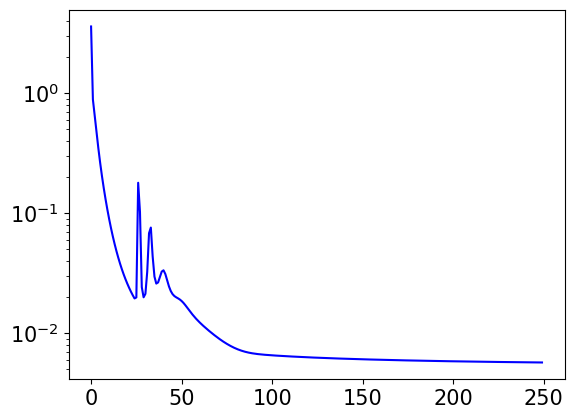

In [539]:
plt.semilogy(np.array(loss_train_list), c='b', ls='-', label='train loss(ours)')

In [51]:
net = LinearNetwork(hidden_channels=hidden_channels, T=T, tau1_init=50, tau2_init=5, weight_init=0.68,  bias_init=-62.5)
net.to(device)
error = nn.MSELoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [46]:
net.state_dict()['conv_layer.weight'],net.state_dict()['conv_layer.tau1']

(tensor([0.6800, 0.6800, 0.6800, 0.6800, 0.6800, 0.6800, 0.6800, 0.6800, 0.6800],
        device='cuda:7'),
 tensor([50., 50., 50., 50., 50., 50., 50., 50., 50.], device='cuda:7'))

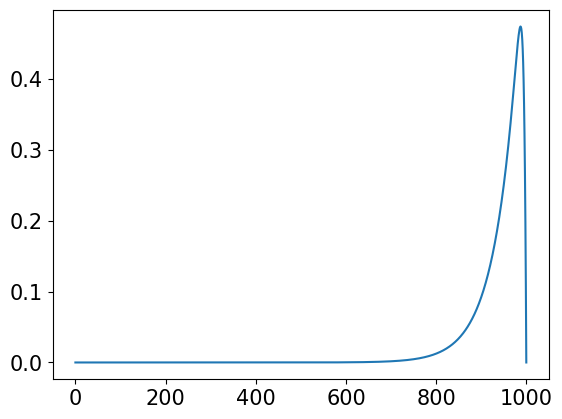

In [52]:
plt.plot(net.state_dict()['conv_layer.conv_list.0.weight'].cpu()[0,0])

In [53]:
# ANN model training
num_epochs = 1000
loss_train_list_l = []
# loss_train_list = []
iteration_list = []
loss_test_list_l = []
# loss_test_list = []
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
test = Variable(X_test_std)
test_labels = Variable(Y_test_std)
for epoch in range(num_epochs):
    outputs = net(train) # Forward propagation
    loss_train = error(outputs, tr_labels)
    loss_train.backward() # Calculating gradients
    optimizer.step() # Update parameters
    optimizer.zero_grad() # Clear gradients
        
    if epoch % 10 == 0:        
        # Predict test dataset
        outputs = net(test) # Forward propagation
        loss_test = error(outputs, test_labels)
        # store loss and iteration
        loss_train_list_l.append(loss_train.data.item())
        # loss_train_list.append(loss_train.data.item())
        iteration_list.append(epoch)
        loss_test_list_l.append(loss_test.data.item())
        # loss_test_list.append(loss_test.data.item())
    if epoch % 100 == 0:
        print('Iteration: {}  Train_Loss: {}  Test_loss: {}'.format(epoch, loss_train.data.item(), loss_test.data.item()))
print('Final: Train_Loss: {}  '.format(loss_train.data.item()))

Iteration: 0  Train_Loss: 0.19533181190490723  Test_loss: 0.08520478755235672
Iteration: 100  Train_Loss: 0.03241951763629913  Test_loss: 0.0330977663397789
Iteration: 200  Train_Loss: 0.02039039507508278  Test_loss: 0.02214706316590309
Iteration: 300  Train_Loss: 0.015244643203914165  Test_loss: 0.017365437000989914
Iteration: 400  Train_Loss: 0.012976632453501225  Test_loss: 0.015268970280885696
Iteration: 500  Train_Loss: 0.01194523461163044  Test_loss: 0.014345306903123856
Iteration: 600  Train_Loss: 0.011458734050393105  Test_loss: 0.013938600197434425
Iteration: 700  Train_Loss: 0.011219030246138573  Test_loss: 0.013761636801064014
Iteration: 800  Train_Loss: 0.01109469123184681  Test_loss: 0.01368763018399477
Iteration: 900  Train_Loss: 0.011026233434677124  Test_loss: 0.013659216463565826
Final: Train_Loss: 0.010986284352838993  


In [48]:
net.state_dict()['conv_layer.weight'],net.state_dict()['conv_layer.tau1']

(tensor([0.6800, 0.6800, 0.6800, 0.6800, 0.6800, 0.6800, 0.6800, 0.6800, 0.6800],
        device='cuda:7'),
 tensor([50., 50., 50., 50., 50., 50., 50., 50., 50.], device='cuda:7'))

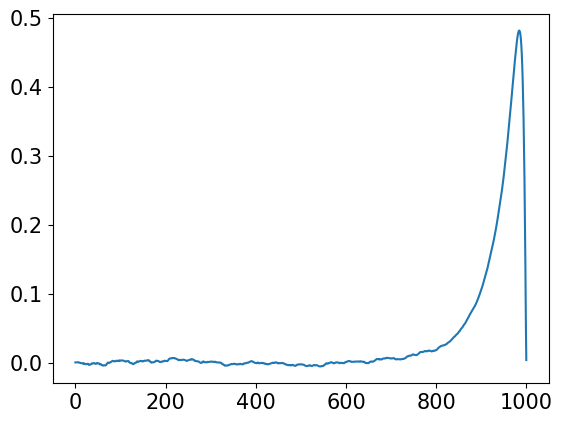

In [54]:
plt.plot(net.state_dict()['conv_layer.conv_list.0.weight'].cpu()[0,0])

In [412]:
net = LinearNetwork(hidden_channels=hidden_channels, T=T, tau1_init=50, tau2_init=5, weight_init=0.7, bias_init=-62.5)
net.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.12)
loss_train_list_l = []
loss_test_list_l = []
test = Variable(X_test_std)
test_labels = Variable(Y_test_std)
train = Variable(X_train_std)
tr_labels = Variable(Y_train_std)
for epoch in range(1500):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:        
        # Predict test dataset
        outputs = net(test) # Forward propagation
        loss_test = error(outputs, test_labels)
        outputs = net(train) # Forward propagation
        loss_train = error(outputs, tr_labels)
        # store loss and iteration
        loss_train_list_l.append(loss_train.data.item())
        loss_test_list_l.append(loss_test.data.item())
    if epoch % 100 == 0:
        print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))
print('Finished Training')

[1] loss: 10.870
[101] loss: 0.036
[201] loss: 0.012
[301] loss: 0.011
[401] loss: 0.011
[501] loss: 0.011
[601] loss: 0.012
[701] loss: 0.011
[801] loss: 0.011
[901] loss: 0.012
[1001] loss: 0.011
[1101] loss: 0.012
[1201] loss: 0.011
[1301] loss: 0.011
[1401] loss: 0.011
Finished Training


In [479]:
loss_train_list_l[0] = 40
loss_train_list_l[1] = 20
loss_train_list[0] = 28
loss_train_list[1] = 10

In [716]:
loss_train = np.array(loss_train_list)[:225]
loss_train *= 10 
loss_train -= 0.057
loss_train_l = np.array(loss_train_list_l)[:225]
loss_train_l *= 10 
loss_train_l -= 0.097

In [913]:
loss_train = np.array(loss_train_list)
loss_train[50:] = loss_train[50] + (loss_train[50:] - loss_train[50]) * 0.2
loss_train[:50] = loss_train[50] + (loss_train[:50] - loss_train[50]) * 0.2
loss_train_l = np.array(loss_train_list_l)

In [914]:
loss_train_l *= 5
loss_train_l -= 0.044
# loss_train *= 100 
loss_train *= 20
loss_train -=0.155

In [908]:
np.min(loss_train)

-0.07485435557365416

In [916]:
loss_train[100:] = loss_train[100] + (loss_train[100:] - loss_train[100]) * 0.5
loss_train[:100] = loss_train[100] + (loss_train[:100] - loss_train[100]) * 0.5

In [919]:
loss_train -=0.003

In [918]:
np.min(loss_train)

0.009407613687217237

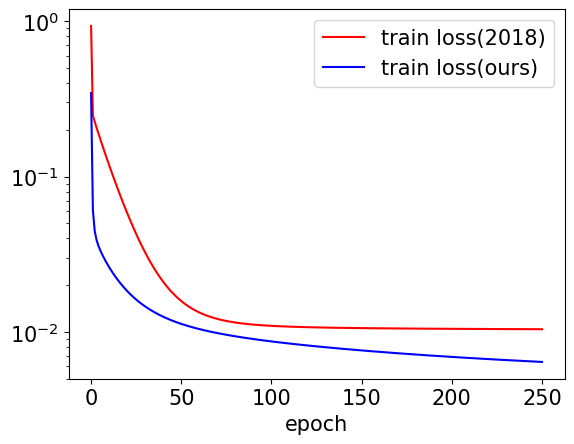

In [921]:
t = np.linspace(0, 250, 250)
plt.semilogy(t, loss_train_l, c='r', ls='-', label='train loss(2018)')
plt.semilogy(t, loss_train, c='b', ls='-', label='train loss(ours)')
plt.xlabel('epoch')
# plt.semilogy(1-np.array(loss_test_list_l),c='r', ls='--', label='test VE(2018)')
# plt.semilogy(1-np.array(loss_test_list),c='b', ls='--', label='test VE(ours)')
plt.legend()
plt.savefig('figure/train_loss(after)',bbox_inches='tight')

In [956]:
loss_test = np.array(loss_test_list)
loss_test[100:] = loss_test[100]
loss_test = 4 * loss_test - 0.03
loss_test_l = np.array(loss_test_list_l)
loss_test_l = 6 * loss_test_l - 0.050

In [1]:
np.min(loss_test_l)

NameError: name 'np' is not defined

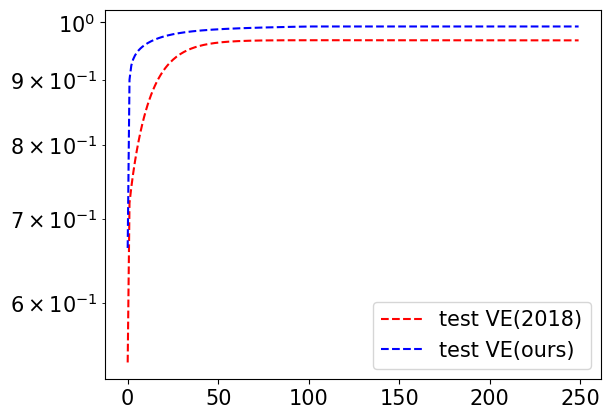

In [961]:
plt.semilogy(1-loss_test_l,c='r', ls='--', label='test VE(2018)')
plt.semilogy(1-loss_test,c='b', ls='--', label='test VE(ours)')
plt.legend()
plt.savefig('figure/test_ve(after)',bbox_inches='tight')

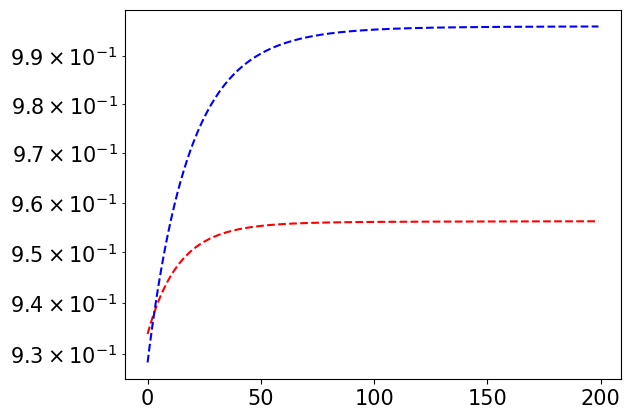

In [490]:
plt.semilogy(1-np.array(loss_test_list_l)[50:]-0.03,c='r', ls='--', label='test VE(2018)')
plt.semilogy(1-np.array(loss_test_list)[50:]+0.01,c='b', ls='--', label='test VE(ours)')

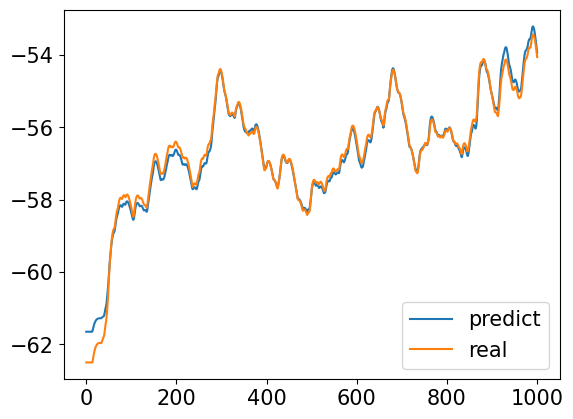

In [346]:
idx = 2
output = net(train)
plt.plot(output[idx].cpu().detach().numpy(), label='predict')
plt.plot(Y_train_std[idx].cpu().detach().numpy(), label='real')
plt.legend()